In [134]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from shapely.geometry import LineString, Polygon, Point, GeometryCollection
from collections import Counter
import osmnx
import pandas as pd

In [2]:
#recuperation des données

ds = xr.open_dataset("c:/Users/paoliniart/Documents/EFAS_historical_2002_Isere.nc") #fond de carte EFAS
gdf = gpd.read_file("pipes.geojson")  

In [41]:
lakesAndPlants = GeometryCollection(list(gdf[gdf["geometry"].type == "Polygon"]["geometry"]) + list(gdf[gdf["geometry"].type == "Point"]["geometry"]))

Text(0.5, 1.0, 'pipeline - Isère et Savoie')

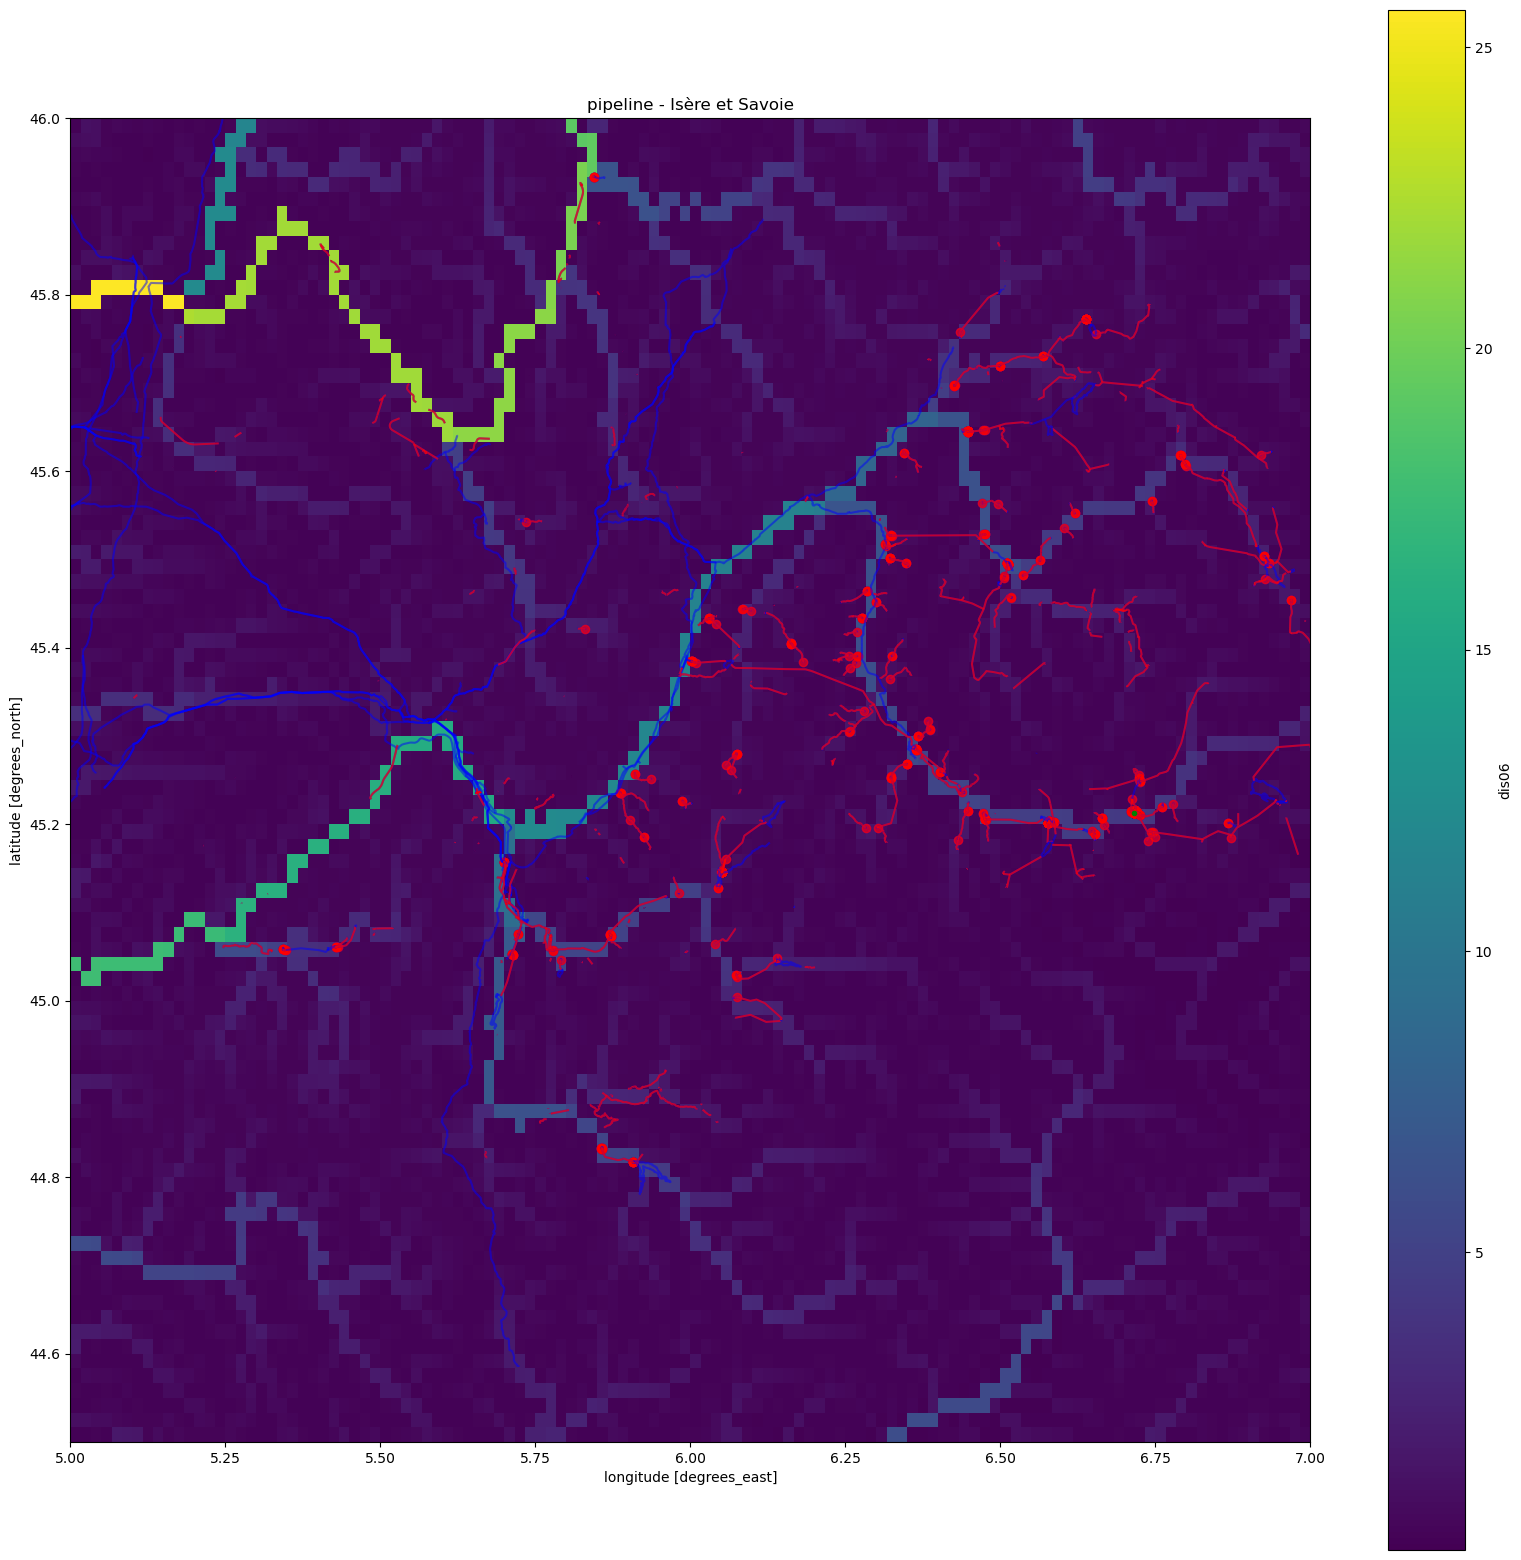

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20))
(ds.mean(dim = "valid_time").dis06**0.5).plot(ax = ax)
gdf.plot(ax=ax, color='blue', alpha=0.5)
gdf[gdf["waterway"].notna() | (gdf['substance'] == "water") | gdf.geometry.intersects(lakesAndPlants)].plot(ax=ax, color='red', alpha=0.7)
ax.plot([6.716161], [45.2128228], 'g.')
ax.set_ylim(44.5, 46)
plt.title("pipeline - Isère et Savoie")



In [110]:
water = gdf[gdf["waterway"].notna() | (gdf['substance'] == "water") | gdf.geometry.intersects(lakesAndPlants)]
efas_dem = xr.open_dataset("c:/Users/paoliniart/Documents/elv_European_01min.nc") #dem utilisé pour les tuyaux

In [111]:
pipes = water[water.geometry.type == "LineString"]

In [119]:
edges = []
nodes_set = set()

for idx, row in pipes.iterrows():
    coords = list(row.geometry.coords)
    for i in range(len(coords)-1):
        u = coords[i]
        v = coords[i+1]
        edges.append({"u": u, "v": v, "key": 0, "geometry": LineString([u,v])})
        nodes_set.add(u)
        nodes_set.add(v)

edges_gdf = gpd.GeoDataFrame(edges)

nodes_gdf = gpd.GeoDataFrame([
    {"x": n[0], "y": n[1], "geometry": Point(n)}
    for n in nodes_set
])

In [120]:
edges_gdf = gpd.GeoDataFrame(edges)
edges_gdf['u'] = edges_gdf['u'].apply(tuple)
edges_gdf['v'] = edges_gdf['v'].apply(tuple)
edges_gdf = edges_gdf.set_index(['u', 'v', 'key'])


nodes_gdf['node'] = nodes_gdf.apply(lambda r: (r['x'], r['y']), axis=1)
nodes_gdf = nodes_gdf.set_index('node')

In [127]:
edges_gdf = edges_gdf.drop_duplicates()

In [128]:
pipes = osmnx.graph_from_gdfs(nodes_gdf, edges_gdf)

In [129]:
simplifiedGraph = osmnx.simplify_graph(pipes)

In [130]:
fig, ax = plt.subplots(1, 1, figsize = (150, 150))
(ds.mean(dim = "valid_time").dis06**0.5).plot(ax = ax)
gdf[gdf["waterway"].notna()].plot(ax=ax, color='red', alpha=0.3)

for l in list(simplifiedGraph.edges) :
    coord = np.array(l[:-1])
    alt_start = efas_dem.sel(lat = coord[0, 1], lon = coord[0, 0], method = "nearest").Band1.values
    alt_end = efas_dem.sel(lat = coord[1, 1], lon = coord[1, 0], method = "nearest").Band1.values
    if alt_start >= alt_end :
        ax.arrow(coord[0, 0], coord[0, 1], coord[1, 0] - coord[0, 0], coord[1, 1] - coord[0, 1], color = 'green')
    else : 
        ax.arrow(coord[0, 0], coord[0, 1], coord[1, 0] - coord[0, 0], coord[1, 1] - coord[0, 1], color = 'yellow')


In [131]:
simplifiedGraphEFAS = []

for l in list(simplifiedGraph.edges) :
    coord = np.array(l[:-1])
    lat_s = efas_dem.sel(lat = coord[0, 1], lon = coord[0, 0], method = "nearest").lat.values
    lon_s = efas_dem.sel(lat = coord[0, 1], lon = coord[0, 0], method = "nearest").lon.values
    lat_e = efas_dem.sel(lat = coord[1, 1], lon = coord[1, 0], method = "nearest").lat.values
    lon_e = efas_dem.sel(lat = coord[1, 1], lon = coord[1, 0], method = "nearest").lon.values
    if (lat_s == lat_e) & (lon_s == lon_e) :
        continue
    else :
        simplifiedGraphEFAS.append([(lon_s, lat_s), (lon_e, lat_e)])

fig, ax = plt.subplots(1, 1, figsize = (150, 150))
(ds.mean(dim = "valid_time").dis06**0.5).plot(ax = ax)
gdf[gdf["waterway"].notna()].plot(ax=ax, color='red', alpha=0.3)

for l in simplifiedGraphEFAS :
    coord = np.array(l)
    ax.arrow(coord[0, 0], coord[0, 1], coord[1, 0] - coord[0, 0], coord[1, 1] - coord[0, 1], color = 'green')


In [140]:
pd.DataFrame(simplifiedGraphEFAS).to_csv("pipes.csv")

In [145]:
for i in pd.DataFrame(simplifiedGraphEFAS).values :
    print(i)

[(array(5.875), array(45.625)) (array(5.875), array(45.64166667))]
[(array(5.94166667), array(45.575)) (array(5.925), array(45.575))]
[(array(5.75833333), array(45.075))
 (array(5.75833333), array(45.09166667))]
[(array(5.75833333), array(45.09166667))
 (array(5.70833333), array(45.10833333))]
[(array(5.775), array(45.05833333))
 (array(5.75833333), array(45.05833333))]
[(array(5.775), array(45.05833333)) (array(5.75833333), array(45.075))]
[(array(5.775), array(45.05833333)) (array(5.775), array(45.075))]
[(array(5.775), array(45.05833333)) (array(5.775), array(45.075))]
[(array(5.69166667), array(45.375)) (array(5.74166667), array(45.425))]
[(array(5.55833333), array(45.625)) (array(5.525), array(45.65833333))]
[(array(5.55833333), array(45.625))
 (array(5.59166667), array(45.60833333))]
[(array(5.55833333), array(45.625))
 (array(5.55833333), array(45.60833333))]
[(array(5.69166667), array(45.10833333))
 (array(5.69166667), array(45.125))]
[(array(5.69166667), array(45.10833333))
 (